In [1]:
from langchain_groq import ChatGroq
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, Annotated, List
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, AIMessage, ChatMessage
from langchain.agents import tool
from langchain_tavily import TavilySearch

import time
from dotenv import load_dotenv
import os



load_dotenv()
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
os.environ["TAVILY_API_KEY"] = "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"




In [2]:

llm = ChatGroq(model="llama3-8b-8192")

In [ ]:
tool = TavilySearch(
    max_results=5,
    search_depth="advanced"
    # include_answer=False,
    # include_raw_content=False,
    # include_images=False,
    # include_image_descriptions=False,
    # search_depth="basic",
    # time_range="day",
    # include_domains=None,
    # exclude_domains=None
)

In [5]:
tool.invoke({"query": "What happened at the last wimbledon"})

{'query': 'What happened at the last wimbledon',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'title': 'What happened last year? - The Athletic - The New York Times',
   'url': 'https://www.nytimes.com/athletic/live-blogs/wimbledon-2024-live-updates-alcaraz-djokovic-mens-final-result/kJJdTKhOgkZo/mGpXBR2QIift/',
   'content': 'Wimbledon 2024 live updates: Carlos Alcaraz defeats Novak Djokovic in straight sets to defend his crown In the 2023 final, Carlos Alcaraz won his first Wimbledon title, and only his second Grand Slam title, after beating Novak Djokovic in a five-set thriller on Centre Court. GO FURTHER Novak Djokovic and Carlos Alcaraz’s Wimbledon final is a duel of extraordinary quests Novak Djokovic set up a Wimbledon rematch with Carlos Alcaraz by beating Lorenzo Musetti, 6-4, 7-6, 6-3 on Centre Court on Friday, concluding his run to the final at the All England Club that started just 25 days after surgery on a torn meniscus in his right knee. GO

### Second Approach Testing

In [ ]:
from langchain_core.messages import BaseMessage

class AgentState(TypedDict):
    user_input: str
    project_type: str
    city: str
    geo_state: str
    legal_info_found: bool
    legal_summary: str
    suggested_websites: List[str]
    project_roadmap: str
    route_decision: str # NEW: To explicitly guide conditional routing

In [4]:
tavily_search_tool = TavilySearch(max_results=2, search_depth="advanced")
tools = [tavily_search_tool]

In [5]:
from pydantic import BaseModel, Field

class ProjectLocation(BaseModel):
    project_type: str = Field(description="The type of construction project, e.g., 'window replacement', 'building a deck', 'converting a garage'.")
    city: str = Field(description="The city where the project is located.")
    geo_state: str = Field(description="The state where the project is located (e.g., 'California').") # RENAMED 'state' to 'geo_state'


In [ ]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
import json


def parse_user_input(state: AgentState):
    user_input = state["user_input"]
    
    prompt_parser = ChatPromptTemplate.from_messages([
        ("system", "You are a helpful assistant that extracts project details from user queries. Identify the project type, city, and state."),
        ("human", "{query}")
    ])
    
    parser_chain = prompt_parser | llm.with_structured_output(ProjectLocation)
    
    extracted_project_type = ""
    extracted_city = ""
    extracted_geo_state = "" # RENAMED

    try:
        parsed_info: ProjectLocation = parser_chain.invoke({"query": user_input})
        
        extracted_project_type = parsed_info.project_type
        extracted_city = parsed_info.city
        extracted_geo_state = parsed_info.geo_state # RENAMED

    except Exception as e:
        print(f"Warning: Could not extract structured info from LLM. Error: {e}")
        # Consider adding a fall-back or re-prompting logic here
        # For now, it will return empty strings and subsequent steps might fail
        pass # Allow empty strings to pass, or raise an error to stop execution
        
    return {
        "project_type": extracted_project_type,
        "city": extracted_city,
        "geo_state": extracted_geo_state, # RENAMED
        "chat_history": state["chat_history"] + [HumanMessage(content=user_input)] # Ensure proper message type
    }

In [ ]:
def legal_search_agent(state: AgentState):
    project_type = state["project_type"]
    city = state["city"]
    geo_state = state["geo_state"] # RENAMED
    
    queries = [
        f"owner-builder rights {city}, {geo_state}",
        f"{project_type} permit requirements {city}, {geo_state}",
        f"zoning laws {city}, {geo_state} {project_type} construction",
        f"local construction ordinances {city}, {geo_state}",
        f"building codes {project_type} {city}, {geo_state}"
    ]
    
    all_valid_search_results = []
    legal_info_found = False

    for query in queries:
        print(f"Searching Tavily for: {query}")
        try:
            tavily_response_dict = tavily_search_tool.invoke({"query": query}) 
            
            if isinstance(tavily_response_dict, dict) and 'results' in tavily_response_dict:
                results_list = tavily_response_dict['results']
            else:
                print(f"Warning: TavilySearch did not return expected dictionary with 'results' key for query '{query}'. Actual response: {tavily_response_dict}")
                continue 

            print(f"Tavily raw response for '{query}': {tavily_response_dict}")
            print(f"Extracted results list type: {type(results_list)}")

            valid_results_for_query = []
            if isinstance(results_list, list):
                for r in results_list:
                    if isinstance(r, dict) and 'url' in r and 'content' in r:
                        valid_results_for_query.append(r)
                    else:
                        print(f"Warning: Unexpected format in Tavily result item: {r}")
                
                if valid_results_for_query:
                    all_valid_search_results.extend(valid_results_for_query)
                    legal_info_found = True
            else:
                print(f"Warning: 'results' key content was not a list for query '{query}'. Content type: {type(results_list)}")

        except Exception as e:
            print(f"Error during Tavily search for '{query}': {e}")
            # Handle search errors gracefully, maybe log them or set a flag

    search_summary = "\n\n".join([f"Source: {r['url']}\nContent: {r['content']}" for r in all_valid_search_results])
    
    return {
        "legal_info_found": legal_info_found,
        "legal_summary": search_summary,
        "chat_history": state["chat_history"]
    }


In [8]:
def analyze_and_summarize(state: AgentState):
    legal_info_found = state["legal_info_found"]
    legal_summary_raw = state["legal_summary"]
    project_type = state["project_type"]
    city = state["city"]
    geo_state = state["geo_state"]

    if legal_info_found and legal_summary_raw:
        prompt_summarizer = ChatPromptTemplate.from_messages([
            ("system", f"You are a legal expert. Synthesize the following search results to provide a clear, concise summary of owner-builder rights, permit requirements, zoning laws, and local construction ordinances for a {project_type} project in {city}, {geo_state}. Focus on actionable information for an owner-builder. If a specific piece of information isn't found, state that it's not available in the provided results. Cite sources by URL if possible."),
            ("human", "Here are the search results:\n\n{search_results}")
        ])
        summary_chain = prompt_summarizer | llm
        final_legal_summary = summary_chain.invoke({"search_results": legal_summary_raw}).content
        
        # Return a decision for routing
        return {
            "legal_summary": final_legal_summary,
            "suggested_websites": [],
            "chat_history": state["chat_history"] + [AIMessage(content=final_legal_summary)],
            "route_decision": "roadmap" # Signal to go to roadmap generation
        }
    else:
        # If no specific info, suggest government websites
        suggested_websites = [
            f"Try searching for '{city} building department' or '{geo_state} contractor licensing board' on Google.",
            f"Look for the official website of the City of {city} planning or zoning department."
        ]
        
        prompt_suggest_websites = ChatPromptTemplate.from_messages([
            ("system", f"Based on the request for legal information for a {project_type} project in {city}, {geo_state}, and the fact that specific detailed information was not readily found, suggest relevant official government websites (e.g., city building department, state contractor board, zoning office) where the user can find more information. Provide direct URLs if possible based on a general search for these entities. Format as a numbered list of URLs and descriptions."),
            ("human", f"Suggest websites for {city}, {geo_state} related to {project_type} permits, zoning, and owner-builder information.")
        ])
        
        suggested_websites_text = llm.invoke(prompt_suggest_websites.format(project_type=project_type, city=city, geo_state=geo_state)).content
        suggested_websites = [line.strip() for line in suggested_websites_text.split('\n') if line.strip()]

        final_summary = f"No specific detailed legal information was found for your request about {project_type} in {city}, {geo_state}. Here are some general government websites you might consult:\n" + "\n".join(suggested_websites)
        
        # Return a decision for routing
        return {
            "legal_info_found": False, # Keep this for output, but routing uses "route_decision"
            "legal_summary": final_summary,
            "suggested_websites": suggested_websites,
            "chat_history": state["chat_history"] + [AIMessage(content=final_summary)],
            "route_decision": "websites" # Signal to go to website suggestions
        }

In [ ]:
def generate_project_roadmap(state: AgentState) -> dict:
    legal_summary = state["legal_summary"]
    project_type = state["project_type"]
    city = state["city"]
    geo_state = state["geo_state"]

    prompt_roadmap = ChatPromptTemplate.from_messages([
        ("system",
         f"You are a project manager expert. Based on the following legal information for a {project_type} project in {city}, {geo_state}, outline a step-by-step project roadmap from Phase 1: Legal Understanding through Phase 7: Final Inspections. Detail the key actions in each phase. Incorporate the legal requirements where relevant.\n\nLegal Summary:\n{legal_summary}"),
        ("human", "Generate the project roadmap.")
    ])
    roadmap_chain = prompt_roadmap | llm
    roadmap = roadmap_chain.invoke({"legal_summary": legal_summary}).content

    print(f"Generate Project Roadmap: Roadmap created for {project_type} in {city}, {geo_state}.")

    # Only return the state updates, no chat_history
    return {"project_roadmap": roadmap}


In [10]:
def route_to_next_step(state: AgentState):
    # This function now reads the 'route_decision' set by the previous node
    return state.get("route_decision", "websites") # Return string, ensure it's a unique node name


In [11]:
workflow = StateGraph(AgentState)

# Add nodes
workflow.add_node("parse_user_input", parse_user_input)
workflow.add_node("legal_search_agent", legal_search_agent)
workflow.add_node("analyze_and_summarize", analyze_and_summarize)
# Add a distinct node for suggesting websites
workflow.add_node("suggest_websites_node", analyze_and_summarize) # Re-use analyze_and_summarize logic
workflow.add_node("generate_project_roadmap_node", generate_project_roadmap)

# Set entry point
workflow.set_entry_point("parse_user_input")

# Add edges
workflow.add_edge("parse_user_input", "legal_search_agent")
workflow.add_edge("legal_search_agent", "analyze_and_summarize")

# Conditional edge from analyze_and_summarize
workflow.add_conditional_edges(
    "analyze_and_summarize",
    route_to_next_step,
    {
        "websites": END, # If route_decision is "websites", end
        "roadmap": "generate_project_roadmap_node" # If route_decision is "roadmap", go to roadmap generation
    }
)

workflow.add_edge("generate_project_roadmap_node", END) # End after generating roadmap

# Compile the graph
app = workflow.compile()

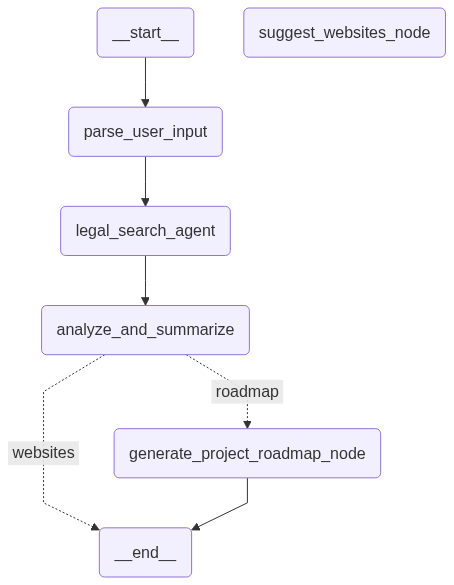

In [12]:
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))

In [13]:
async def run_chatbot(query: str):
    # Initialize all fields in the state
    inputs = {
        "user_input": query,
        "chat_history": [],
        "project_type": "",
        "city": "",
        "geo_state": "", # Use geo_state
        "legal_info_found": False,
        "legal_summary": "",
        "suggested_websites": [],
        "project_roadmap": ""
    }
    
    print("Running query...")
    full_response = []
    async for state in app.astream(inputs):
        # LangGraph streams dictionary updates, not full states at each step
        # So we collect the final state when the graph finishes
        pass # The loop iterates through updates, we just need the final state

    # Access the final state after the stream completes
    final_state = state # 'state' here holds the last accumulated state from the astream loop

    # Check for the presence of outputs and format the response
    if final_state.get("project_roadmap"):
        return f"Here is your project roadmap:\n{final_state['project_roadmap']}"
    elif final_state.get("legal_summary") and not final_state.get("legal_info_found"):
        # This means it went through the 'suggest_websites_node' path
        return final_state['legal_summary'] # This should contain the "no info" message + websites
    else:
        return "I encountered an issue and couldn't process your request. Please try again or rephrase."


In [86]:
import asyncio
import nest_asyncio

# Apply the patch once at the beginning of your notebook or script
nest_asyncio.apply()

In [15]:
print("Running query 1...")
query1 = "I want to replace windows in my house in San Francisco, California. What are the permit requirements?"
response1 = asyncio.run(run_chatbot(query1))
print(f"Chatbot Response 1:\n{response1}\n")

Running query 1...
Running query...
Searching Tavily for: owner-builder rights San Francisco, California
Tavily raw response for 'owner-builder rights San Francisco, California': {'query': 'owner-builder rights San Francisco, California', 'follow_up_questions': None, 'answer': None, 'images': [], 'results': [{'title': "PROPERTY OWNER'S DISCLOSURES - City and County of San Francisco", 'url': 'https://www.sf.gov/file/owner-builder-handout-package', 'content': "you may be held liable for damages. If you obtain a permit as Owner-Builder and wish to hire Contractors, you will be responsible for verifying whether or not those Contractors are properly licensed and the status of their workers' compensation insurance coverage. Central Permit Bureau 49 South Van Ness Avenue, Suite 200 - San Francisco CA", 'score': 0.7482976, 'raw_content': None}, {'title': 'PDF', 'url': 'https://www2.cslb.ca.gov/Resources/GuidesAndPublications/OwnerBuildersPamphlet.pdf', 'content': 'website: www.cslb.ca.gov or t

In [22]:
class TavilyResult(TypedDict):
    title: str
    content: str
    url: str

In [4]:
from langchain_core.messages import BaseMessage
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()


class AgentState(TypedDict):
    user_input: str
    project_type: str
    city: str
    geo_state: str
    legal_info_found: bool
    legal_summary: str
    suggested_websites: List[str]
    project_roadmap: str
    route_decision: str # NEW: To explicitly guide conditional routin
    tavily_search_results: List[TavilyResult] 

In [5]:
tavily_search_tool = TavilySearch(max_results=2, search_depth="advanced")
tools = [tavily_search_tool]

In [6]:
from typing import Optional


class TavilyFullResponse(TypedDict):
    query: str
    follow_up_questions: Optional[List[str]]
    answer: Optional[str]
    images: List[str]
    results: List[TavilyResult]
    response_time: float

In [7]:
MOCKED_TAVILY_RESPONSES = {
    "owner-builder rights San Francisco, California": {
        'query': 'owner-builder rights San Francisco, California',
        'follow_up_questions': None,
        'answer': None,
        'images': [],
        'results': [
            {'title': "PROPERTY OWNER'S DISCLOSURES - City and County of San Francisco", 'url': 'https://www.sf.gov/file/owner-builder-handout-package', 'content': "you may be held liable for damages. If you obtain a permit as Owner-Builder and wish to hire Contractors, you will be responsible for verifying whether or not those Contractors are properly licensed and the status of their workers' compensation insurance coverage. Central Permit Bureau 49 South Van Ness Avenue, Suite 200 - San Francisco CA", 'score': 0.7482976, 'raw_content': None},
            {'title': 'PDF', 'url': 'https://www2.cslb.ca.gov/Resources/GuidesAndPublications/OwnerBuildersPamphlet.pdf', 'content': 'website: www.cslb.ca.gov or toll-free automated line: 800.321.CSLB (2752). ContraCtors state LiCense Board . P.O. Box 26000 Sacramento, CA 95826-0026 ... An owner-builder is what the term indicates: the person owns the property and acts as the general contractor on the job, and either does the work or', 'score': 0.466433, 'raw_content': None}
        ],
        'response_time': 1.12
    },
    "window replacement permit requirements San Francisco, California": {
        'query': 'window replacement permit requirements San Francisco, California',
        'follow_up_questions': None,
        'answer': None,
        'images': [],
        'results': [
            {'title': 'San Francisco Window Replacement Permit Guide for Contractors', 'url': 'https://www.insightglass.com/san-francisco-window-replacement-permit/', 'content': "Understanding San Francisco's Window Permit Process. Window replacement in San Francisco isn't as simple as swapping one pane for another. Because of the city's strict planning code and unique architecture, contractors must navigate several rules before starting. In most cases, a building permit is required for replacement windows", 'score': 0.898277, 'raw_content': None},
            {'title': 'PDF', 'url': 'https://sfplanning.org/sites/default/files/documents/publications/Standards_Window_Replacement.pdf', 'content': 'in regard to window replacement and neighborhood character, the Department developed this Window Replacement Standards handout. This document also answers questions regarding what materials are required to be submitted to review a permit application for the repair, rehabilitation, restoration, or replacement of windows in San Francisco. Please', 'score': 0.8095324, 'raw_content': None}
        ],
        'response_time': 1.55
    },
    "zoning laws San Francisco, California window replacement construction": {
        'query': 'zoning laws San Francisco, California window replacement construction',
        'follow_up_questions': None,
        'answer': None,
        'images': [],
        'results': [
            {'title': 'Do You Need a Permit to Replace Windows? - insightglass.com', 'url': 'https://www.insightglass.com/do-you-need-a-permit-to-replace-windows-understanding-bay-area-building-codes/', 'content': 'Image 7: Do you need a permit to replace windows in Bay Area **Why Permits Matter for Window Replacements in the Bay Area** Replacing windows in your home or commercial property is more than just an aesthetic upgrade—it plays a vital role in energy efficiency, safety, and compliance with local building regulations. In the **San Francisco Bay Area**, understanding whether you need a permit for window replacements can save you from costly fines, project delays, and compliance issues. **Do You Need a Permit to Replace Windows in the Bay Area?** **California’s Building Energy Efficiency Standards (Title 24)** require that window replacements meet: You can complete your window replacement hassle-free by following the proper steps, checking city-specific regulations, and working with an experienced installer like **Insight Glass**.', 'score': 0.49348235, 'raw_content': None},
            {'title': 'PDF', 'url': 'https://sfplanning.org/sites/default/files/documents/publications/Standards_Window_Replacement.pdf', 'content': 'questions regarding window replacement. The Planning counter can be reached at 628.652.7300 or pic@sfgov.org. For more information, please also review the How to Apply for a Window Replacement Permit Handout & Checklist. DO I NEED A BUILDING PERMIT TO REPLACE WINDOWS? ALL replacement windows that are visible from a', 'score': 0.34727195, 'raw_content': None}
        ],
        'response_time': 1.13
    },
    "local construction ordinances San Francisco, California": {
        'query': 'local construction ordinances San Francisco, California',
        'follow_up_questions': None,
        'answer': None,
        'images': [],
        'results': [
            {'title': 'Current San Francisco building codes | SF.gov', 'url': 'https://www.sf.gov/resource--2022--current-san-francisco-building-codes', 'content': "Current San Francisco building codes | SF.gov Current San Francisco building codes The Codes include Building, Plumbing, Electrical, Mechanical, Energy and Green Building Codes. 2022 San Francisco Code Amendments ### Highlights from the 2016 SF Building Code The following ordinances were incorporated into the 2016 San Francisco Building Code. 2016-02-08Ordinance 33-16 Conditional Use Required to Remove Any Residential Unit,including an Unauthorized Unit 2016-03-01Ordinance 51-16 Mandatory Disability Access Improvements; Building Owner's Notice to Tenant; Administrative Fee 2016-03-23Ordinance 53-16 All Gender Toilet Facilities 2016-04-12Ordinance 59-16 Permit Suspension for Repeat Violations 2016-04-04Ordinance 60-16 Code Enforcement Procedures 2016-04-04Ordinance 64-16 Stormwater Management Requirements 2016-04-19Ordinance 67-16 Building Facade Inspection and Maintenance and Establishing Fee 2016-03-01Ordinance 71-16 Better Roof Requirements for Renewable Energy Facilities 2016-04-19Ordinance 165-16 Fire, Housing, Building Codes - Fire Safety Requirements for Existing Buildings 2016-07-26Ordinance 221-16 Better Roof Requirements, Including Living Roofs 2017-10-17 2019 San Francisco Code Amendments: Building Code Amendments Existing Building Code Amendments Electrical Code Amendments Mechanical Code Amendments Plumbing Code Amendments Green Building Code Amendments", 'score': 0.98539, 'raw_content': None},
            {'title': 'SF Municipal Codes | SFGOV', 'url': 'https://www.sfgov.org/services/sf-municipal-codes', 'content': 'SF Municipal Codes | SFGOV Visit San Francisco’s new website, SF.gov Skip to main content Open OPEN GOV ONLINE SERVICES HELP Accessibility Services Main menu Download viewers, Text Only, Listen Now  Search form Search  Search form Search  Main menu OPEN GOV ONLINE SERVICES HELP SF Municipal Codes SF Municipal Codes Get access to the San Francisco Charter and a variety of Municipal Codes that establish the legal foundations of the City and County of San Francisco. https://codelibrary.amlegal.com/codes/san_francisco/ Services Category:\xa0 OpenGov OpenGov Sub Category:\xa0 Legislation & Codes City Attorney Share SHARE THIS Powered by Translate Thanks for sharing! - Service 24x7 City and County of San Francisco Original text Rate this translation Your feedback will be used to help improve Google Translate', 'score': 0.98349, 'raw_content': None}
        ],
        'response_time': 0.74
    },
    "building codes window replacement San Francisco, California": {
        'query': 'building codes window replacement San Francisco, California',
        'follow_up_questions': None,
        'answer': None,
        'images': [],
        'results': [
            {'title': 'Standards and Recommendations for Window Replacement', 'url': 'https://sfplanning.org/resource/standards-and-recommendations-window-replacement', 'content': 'Standards and Recommendations for Window Replacement | SF Planning Public Hearings Planning Commission Hearings Public Notices for Project Applications Window Replacement Windows are an integral part of the design and character of most buildings, and choosing appropriate replacement windows is frequently a critical aspect of any rehabilitation project. To assist with your window replacement project, this document includes information on: Frequently Asked Questions – Repair & Replacement of Historic Windows You are encouraged to review the step-by-step window replacement guide or contact us with any questions before you commit to any purchase of materials. Note: a building permit is required for all types of window replacement (despite the location on a building) including enlarging existing windows or adding new windows openings.', 'score': 0.98538, 'raw_content': None},
            {'title': 'Current San Francisco building codes | SF.gov', 'url': 'https://www.sf.gov/resource--2022--current-san-francisco-building-codes', 'content': "Current San Francisco building codes | SF.gov Current San Francisco building codes The Codes include Building, Plumbing, Electrical, Mechanical, Energy and Green Building Codes. 2022 San Francisco Code Amendments ### Highlights from the 2016 SF Building Code The following ordinances were incorporated into the 2016 San Francisco Building Code. 2016-02-08Ordinance 33-16 Conditional Use Required to Remove Any Residential Unit,including an Unauthorized Unit 2016-03-01Ordinance 51-16 Mandatory Disability Access Improvements; Building Owner's Notice to Tenant; Administrative Fee 2016-03-23Ordinance 53-16 All Gender Toilet Facilities 2016-04-12Ordinance 59-16 Permit Suspension for Repeat Violations 2016-04-04Ordinance 60-16 Code Enforcement Procedures 2016-04-04Ordinance 64-16 Stormwater Management Requirements 2016-04-19Ordinance 67-16 Building Facade Inspection and Maintenance and Establishing Fee 2016-03-01Ordinance 71-16 Better Roof Requirements for Renewable Energy Facilities 2016-04-19Ordinance 165-16 Fire, Housing, Building Codes - Fire Safety Requirements for Existing Buildings 2016-07-26Ordinance 221-16 Better Roof Requirements, Including Living Roofs 2017-10-17 2019 San Francisco Code Amendments: Building Code Amendments Existing Building Code Amendments Electrical Code Amendments Mechanical Code Amendments Plumbing Code Amendments Green Building Code Amendments", 'score': 0.98201, 'raw_content': None}
        ],
        'response_time': 1.68
    }
}


In [8]:
class MockTavilySearchTool:
    def invoke(self, input_dict: dict) -> dict:
        query = input_dict.get("query", "")
        print(f"**Mock Tavily Search for: '{query}' (using hardcoded data)**") # Clearly indicate it's a mock call

        if query in MOCKED_TAVILY_RESPONSES:
            return MOCKED_TAVILY_RESPONSES[query]
        else:
            # Fallback for unexpected queries: return empty results
            print(f"Warning: No mock response found for query: '{query}'. Returning empty results.")
            return {
                "query": query,
                "follow_up_questions": None,
                "answer": None,
                "images": [],
                "results": [],
                "response_time": 0.0
            }

# --- IMPORTANT: Replace your actual Tavily tool with this mock one ---
tavily_search_tool = MockTavilySearchTool()

In [9]:
from pydantic import BaseModel, Field

class ProjectLocation(BaseModel):
    project_type: str = Field(description="The type of construction project, e.g., 'window replacement', 'building a deck', 'converting a garage'.")
    city: str = Field(description="The city where the project is located.")
    geo_state: str = Field(description="The state where the project is located (e.g., 'California').") # RENAMED 'state' to 'geo_state'


In [10]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder


def parse_user_input(state: AgentState):
    user_input = state["user_input"]
    
    prompt_parser = ChatPromptTemplate.from_messages([
        ("system", "You are a helpful assistant that extracts project details from user queries. Identify the project type, city, and state."),
        ("human", "{query}")
    ])
    
    chain = prompt_parser | llm.with_structured_output(ProjectLocation)
    

    try:
        parsed_info: ProjectLocation = chain.invoke({"query": user_input})
        
        extracted_project_type = parsed_info.project_type
        extracted_city = parsed_info.city
        extracted_geo_state = parsed_info.geo_state # RENAMED

    except Exception as e:
        print(f"Warning: Could not extract structured info from LLM. Error: {e}")
        # Consider adding a fall-back or re-prompting logic here
        # For now, it will return empty strings and subsequent steps might fail
        pass # Allow empty strings to pass, or raise an error to stop execution
        
    return {
        "project_type": extracted_project_type,
        "city": extracted_city,
        "geo_state": extracted_geo_state, # RENAMED
    }

In [11]:
# def legal_search_agent(state: AgentState):
#     project_type = state["project_type"]
#     city = state["city"]
#     geo_state = state["geo_state"] # RENAMED
    
#     queries = [
#         f"owner-builder rights {city}, {geo_state}",
#         f"{project_type} permit requirements {city}, {geo_state}",
#         f"zoning laws {city}, {geo_state} {project_type} construction",
#         f"local construction ordinances {city}, {geo_state}",
#         f"building codes {project_type} {city}, {geo_state}"
#     ]
    
#     all_valid_search_results = []
#     legal_info_found = False

#     for query in queries:
#         print(f"Searching Tavily for: {query}")
#         try:
#             tavily_response_dict = tavily_search_tool.invoke({"query": query})
#             print(f"Tavily Response for '{query}': {tavily_response_dict}")

#             # --- This is the crucial part that extracts from 'results' ---
#             if "results" in tavily_response_dict and isinstance(tavily_response_dict["results"], list):
#                 for result in tavily_response_dict["results"]: # <--- This loop iterates over items IN the 'results' list
#                     # Ensure the result has the expected keys before appending
#                     if all(k in result for k in ["title", "content", "url"]):
#                         all_valid_search_results.append(
#                             TavilyResult(
#                                 title=result["title"],
#                                 content=result["content"],
#                                 url=result["url"]
#                             )
#                         )
#                         legal_info_found = True
#                     else:
#                         print(f"Skipping malformed Tavily result (missing keys): {result}")
#             else:
#                 print(f"Tavily response for '{query}' did not contain a valid 'results' list. Response: {tavily_response_dict}")

#         except Exception as e:
#             print(f"Error during Tavily search for '{query}': {e}")

#     state["tavily_search_results"] = all_valid_search_results
#     state["legal_info_found"] = legal_info_found
#     return state



def legal_search_agent(state: AgentState) -> AgentState:
    # 1. Create a mutable copy of the current state
    new_state = state.copy()

    project_type = new_state["project_type"]
    city = new_state["city"]
    geo_state = new_state["geo_state"]

    # Handle cases where parsing might have failed or input is incomplete
    if project_type == "unknown" or city == "unknown" or geo_state == "unknown":
        print("Legal Search Agent: Skipping search due to unknown project details from user input.")
        new_state["legal_info_found"] = False
        new_state["tavily_search_results"] = []
        # Return the updated new_state with only these changes; other fields remain as they were in 'state'
        return new_state

    queries = [
        f"owner-builder rights {city}, {geo_state}",
        f"{project_type} permit requirements {city}, {geo_state}",
        f"zoning laws {city}, {geo_state} {project_type} construction",
        f"local construction ordinances {city}, {geo_state}",
        f"building codes {project_type} {city}, {geo_state}"
    ]

    all_valid_search_results: List[TavilyResult] = []
    legal_info_found = False

    print("Legal Search Agent: Starting web searches for legal information...")
    for query in queries:
        try:
            print(f"Searching Tavily for: '{query}'")
            tavily_response_dict = tavily_search_tool.invoke({"query": query})

            if "results" in tavily_response_dict and isinstance(tavily_response_dict["results"], list):
                for result in tavily_response_dict["results"]:
                    if all(k in result for k in ["title", "content", "url"]):
                        all_valid_search_results.append(
                            TavilyResult(
                                title=result["title"],
                                content=result["content"],
                                url=result["url"]
                            )
                        )
                        legal_info_found = True
                    else:
                        print(f"Skipping malformed Tavily result (missing 'title', 'content', or 'url'): {result}")
            else:
                print(f"Tavily response for '{query}' did not contain a valid 'results' list or was empty. Response: {tavily_response_dict}")

        except Exception as e:
            print(f"Error during Tavily search for '{query}': {e}")

    # 2. Update the relevant fields in the new_state copy
    new_state["tavily_search_results"] = all_valid_search_results
    new_state["legal_info_found"] = legal_info_found

    print(f"Legal Search Agent: Completed search. Found {len(all_valid_search_results)} valid results. Legal information found: {legal_info_found}")

    # 3. Return the entire updated state copy
    return new_state

In [12]:
def analyze_and_summarize(state: AgentState) -> dict:
    legal_info_found = state["legal_info_found"]
    project_type = state["project_type"]
    city = state["city"]
    geo_state = state["geo_state"]
    tavily_search_results = state["tavily_search_results"]

    if legal_info_found and tavily_search_results:
        formatted_search_results = []
        for i, result in enumerate(tavily_search_results):
            formatted_search_results.append(
                f"--- Result {i+1} ---\n"
                f"Title: {result.get('title', 'N/A')}\n"
                f"URL: {result.get('url', 'N/A')}\n"
                f"Content: {result.get('content', 'N/A')}\n"
                f"-------------------\n"
            )
        search_results_for_llm = "\n".join(formatted_search_results)

        prompt_summarizer = ChatPromptTemplate.from_messages([
            ("system",
             f"You are a legal expert. Synthesize the following search results to provide a clear, concise summary of owner-builder rights, permit requirements, zoning laws, and local construction ordinances for a {project_type} project in {city}, {geo_state}. Focus on actionable information for an owner-builder. "
             "If a specific piece of information isn't found across all provided results, state that it's not available in the provided results. Cite sources by URL for each piece of information extracted from a specific result."),
            ("human", f"Here are the search results:\n\n{search_results_for_llm}")
        ])
        summary_chain = prompt_summarizer | llm
        final_legal_summary = summary_chain.invoke({"search_results": search_results_for_llm}).content

        print(f"Analyze and Summarize: Legal summary generated. Routing to 'roadmap'.")
        return {
            "legal_summary": final_legal_summary,
            "route_decision": "roadmap"
        }


In [13]:
def generate_project_roadmap(state: AgentState) -> dict:
    legal_summary = state["legal_summary"]
    project_type = state["project_type"]
    city = state["city"]
    geo_state = state["geo_state"]

    prompt_roadmap = ChatPromptTemplate.from_messages([
        ("system",
         f"You are a project manager expert. Based on the following legal information for a {project_type} project in {city}, {geo_state}, outline a step-by-step project roadmap from Phase 1: Legal Understanding through Phase 7: Final Inspections. Detail the key actions in each phase. Incorporate the legal requirements where relevant.\n\nLegal Summary:\n{legal_summary}"),
        ("human", "Generate the project roadmap.")
    ])
    roadmap_chain = prompt_roadmap | llm
    roadmap = roadmap_chain.invoke({"legal_summary": legal_summary}).content

    print(f"Generate Project Roadmap: Roadmap created for {project_type} in {city}, {geo_state}.")

    # Only return the state updates, no chat_history
    return {"project_roadmap": roadmap}

In [14]:
# def route_to_next_step(state: AgentState) -> str:
#     print(f"Routing based on: {state['route_decision']}")
#     if state["route_decision"] == "roadmap":
#         return "generate_roadmap"
#     elif state["route_decision"] == "websites":
#         return "suggest_websites_end"
#     else:
#         return "end_process" #

In [15]:
workflow = StateGraph(AgentState)

workflow.add_node("parse_user_input", parse_user_input)
workflow.add_node("legal_search_agent", legal_search_agent)
workflow.add_node("analyze_and_summarize", analyze_and_summarize)
workflow.add_node("generate_roadmap", generate_project_roadmap) # Use the real roadmap generator
# workflow.add_node("suggest_websites_end", lambda state: {"final_output": state["legal_summary"]})


# Set the entry point
workflow.set_entry_point("parse_user_input")

# Define the edges (transitions between nodes)
workflow.add_edge("parse_user_input", "legal_search_agent")
workflow.add_edge("legal_search_agent", "analyze_and_summarize")
workflow.add_edge("analyze_and_summarize", "generate_roadmap")

# Conditional edge from analyze_and_summarize to route
# workflow.add_conditional_edges(
#     "analyze_and_summarize",
#     route_to_next_step, # The router function
#     {
#         "generate_roadmap": "generate_roadmap", # If router returns "generate_roadmap", go to generate_roadmap node
#         "websites": "suggest_websites_end",   # If router returns "websites", go to suggest_websites_end node
#         "end_process": END # Optional: a direct end if something unexpected happens
#     }
# )

# Connect the final nodes to END
workflow.add_edge("generate_roadmap", END)
# workflow.add_edge("suggest_websites_end", END)


memory = MemorySaver()
app = workflow.compile(checkpointer=memory)

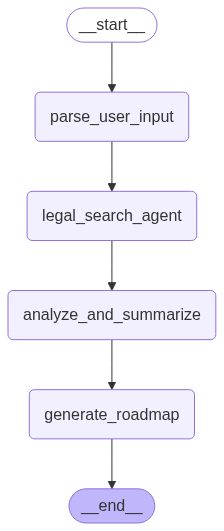

In [ ]:
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))

In [27]:
from typing import TypedDict, Annotated, List, Any, Optional
from langchain_core.messages import AIMessageChunk, HumanMessage, BaseMessage

def _format_value(value: Any) -> Any:
    """Recursively formats values within a stream chunk for better readability."""
    if isinstance(value, AIMessageChunk):
        return f"AIMessageChunk(content='{value.content.strip()}')"
    elif isinstance(value, HumanMessage):
        return f"HumanMessage(content='{value.content.strip()}')"
    # Modified: Check if it's a dict and if it has TavilyResult-like keys
    elif isinstance(value, dict) and all(k in value for k in ['title', 'content', 'url']):
        return {
            'title': value.get('title', 'N/A'),
            'url': value.get('url', 'N/A'),
            'content_preview': (value.get('content', '')[:100] + '...') if value.get('content') else 'N/A'
        }
    elif isinstance(value, dict):
        new_dict = {}
        for k, v in value.items():
            if k == 'tavily_search_results' and isinstance(v, list):
                new_dict[k] = [_format_value(item) for item in v]
            elif k == 'messages' and isinstance(v, list):
                new_dict[k] = [_format_value(item) for item in v]
            else:
                new_dict[k] = _format_value(v)
        return new_dict
    elif isinstance(value, list):
        return [_format_value(item) for item in value]
    return value

In [28]:
thread = {"configurable": {"thread_id": "1"}}
for s in app.stream({
   "user_input":"I want to replace windows in my house in San Francisco, California. What are the permit requirements?"
}, thread, stream_mode="updates"):
    print(s)
    print("-" * 30)

{'parse_user_input': {'project_type': 'window replacement', 'city': 'San Francisco', 'geo_state': 'California'}}
------------------------------
Legal Search Agent: Starting web searches for legal information...
Searching Tavily for: 'owner-builder rights San Francisco, California'
**Mock Tavily Search for: 'owner-builder rights San Francisco, California' (using hardcoded data)**
Searching Tavily for: 'window replacement permit requirements San Francisco, California'
**Mock Tavily Search for: 'window replacement permit requirements San Francisco, California' (using hardcoded data)**
Searching Tavily for: 'zoning laws San Francisco, California window replacement construction'
**Mock Tavily Search for: 'zoning laws San Francisco, California window replacement construction' (using hardcoded data)**
Searching Tavily for: 'local construction ordinances San Francisco, California'
**Mock Tavily Search for: 'local construction ordinances San Francisco, California' (using hardcoded data)**
Searc

In [18]:
from langchain_community.tools import DuckDuckGoSearchResults

search = DuckDuckGoSearchResults()

search.invoke("Obama")

"snippet: Obama's father, Barack Obama, Sr., was a teenage goatherd in rural Kenya, won a scholarship to study in the United States, and eventually became a senior economist in the Kenyan government.Obama's mother, S. Ann Dunham, grew up in Kansas, Texas, and Washington state before her family settled in Honolulu.In 1960 she and Barack Sr. met in a Russian language class at the University of Hawaii ..., title: Barack Obama | Biography, Parents, Education, Presidency, Books ..., link: https://www.britannica.com/biography/Barack-Obama, snippet: Obama could hold his own event, in Washington or somewhere nearby. It would get tons of attention and drive Trump crazy, especially if it draws a bigger crowd. Better yet, make it a parade, or ..., title: Where Is Barack Obama? - The Atlantic, link: https://www.theatlantic.com/politics/archive/2025/06/obama-retirement-trump-era/683068/, snippet: Former President Barack Obama has kept busy since he left office. From impromptu family vacations to co

In [19]:
import gradio as gr

c:\Users\Hannan\anaconda3\envs\myenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
from pprint import pformat


def get_stream_updates(user_query: str):
    """
    Runs the LangGraph app with stream_mode="updates" and yields each update
    for display in Gradio, indicating a thinking phase and final response.
    """
    from langgraph.checkpoint.memory import MemorySaver
    from langgraph.graph import StateGraph, END
    import time

    # Define nodes (these are taken from your provided code, assumed to be already defined)
    # The functions parse_user_input, legal_search_agent, analyze_and_summarize, generate_project_roadmap
    # and the MockLLM, MockTavilySearchTool are assumed to be defined globally or passed in.

    # Re-define ProjectLocation and AgentState for clarity within the function scope if needed,
    # but since they are at the top-level of your code, they are already available.

    # Define the graph and compile it (copied from your provided code)
    workflow = StateGraph(AgentState)
    workflow.add_node("parse_user_input", parse_user_input)
    workflow.add_node("legal_search_agent", legal_search_agent)
    workflow.add_node("analyze_and_summarize", analyze_and_summarize)
    workflow.add_node("generate_roadmap", generate_project_roadmap)

    workflow.set_entry_point("parse_user_input")
    workflow.add_edge("parse_user_input", "legal_search_agent")
    workflow.add_edge("legal_search_agent", "analyze_and_summarize")
    workflow.add_edge("analyze_and_summarize", "generate_roadmap")
    workflow.add_edge("generate_roadmap", END)

    memory = MemorySaver()
    app = workflow.compile(checkpointer=memory)

    # Initialize state for the stream call
    thread = {"configurable": {"thread_id": "1"}}
    initial_state = {
        "user_input": user_query,
        "messages": [HumanMessage(content=user_query)],
        "project_type": "unknown",
        "city": "unknown",
        "geo_state": "unknown",
        "legal_info_found": False,
        "legal_summary": "",
        "suggested_websites": [],
        "project_roadmap": "",
        "route_decision": ""
    }

    accumulated_output = "Agent is **thinking and processing...**\n\n"
    yield accumulated_output

    final_project_roadmap = ""

    for s in app.stream(initial_state, thread, stream_mode="updates"):
        readable_chunk = _format_value(s)
        formatted_chunk = pformat(readable_chunk, indent=2, width=80)
        accumulated_output += formatted_chunk + "\n" + "-" * 30 + "\n"
        yield accumulated_output

        # Extract the project_roadmap from the last update for the final response
        if 'project_roadmap' in s and s['project_roadmap']:
            final_project_roadmap = s['project_roadmap']

    accumulated_output += "\n" + "=" * 50 + "\n"
    accumulated_output += "**Final Agent Response (Project Roadmap):**\n"
    accumulated_output += final_project_roadmap if final_project_roadmap else "A project roadmap could not be generated."
    yield accumulated_output

In [ ]:
if __name__ == "__main__":
    demo_updates = gr.Interface(
        fn=get_stream_updates,
        inputs=gr.Textbox(
            placeholder="E.g., I want to replace windows in my house in San Francisco, California. What are the permit requirements?",
            label="User Query"
        ),
        outputs=gr.Textbox(
            label="LangGraph Update Stream (Thinking & Final Response)",
            lines=20,
            autoscroll=True,
            show_copy_button=True,
        ),
        title="LangGraph Update Stream Viewer",
        description="Enter a query to see the granular state updates from your LangGraph application as it executes (using `stream_mode='updates'`). Observe the initial 'thinking' phase, followed by detailed updates, and finally the extracted overall agent response.",
        allow_flagging="never",
        theme="soft"
    )

    demo_updates.launch(inbrowser=True, show_api=False)

2025-06-15 04:13:26.332 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-15 04:13:26.333 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-15 04:13:26.422 
  command:

    streamlit run c:\Users\Hannan\anaconda3\envs\myenv\Lib\site-packages\ipykernel_launcher.py [ARGUMENTS]
2025-06-15 04:13:26.423 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-15 04:13:26.423 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-15 04:13:26.424 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-15 04:13:26.426 Thread 'MainThread': missing ScriptRunContext! This warning can be ignor